<a href="https://colab.research.google.com/github/Jarvis017/Text-Summarization/blob/main/text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis

## Imports

In [1]:
from google.colab import drive
from transformers import pipeline
import pandas as pd
import numpy as np
from tqdm import tqdm
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Load the data

In [2]:
data = pd.read_csv('/content/gdrive/My Drive/dataset/booksummaries.txt', delimiter='\t', header=None)
data

,0,1,2,3,4,5,6
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ..."
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...


In [3]:
data = data.rename(columns={6: 'story'})
data.head(10)

,0,1,2,3,4,5,story
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
5,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge..."
6,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger..."
7,2950,/m/012dq,Anyone Can Whistle,Arthur Laurents,NaN,NaN,The story is set in an imaginary American tow...
8,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul..."
9,4082,/m/01b56,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...


## Length of each story(character based)

In [4]:
data['Length'] = data['story'].str.len()
data

,0,1,2,3,4,5,story,Length
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...",5812
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...",6121
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,6642
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...,17134
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,4493
...,...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ...",961
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...,1229
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...,1841
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...,147


## Number of words of each story

In [5]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [6]:
data['Word_count'] = data['story'].apply(word_count)
data.head(10)

,0,1,2,3,4,5,story,Length,Word_count
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...",5812,957
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...",6121,998
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,6642,1119
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...,17134,2825
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,4493,722
5,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...",4283,770
6,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger...",5850,1066
7,2950,/m/012dq,Anyone Can Whistle,Arthur Laurents,NaN,NaN,The story is set in an imaginary American tow...,7263,1297
8,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul...",319,56
9,4082,/m/01b56,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...,1786,291


In [7]:
data = data.drop([0, 1, 2, 3, 4, 5], axis=1)
data

,story,Length,Word_count
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957
1,"Alex, a teenager living in near-future Englan...",6121,998
2,The text of The Plague is divided into five p...,6642,1119
3,The argument of the Enquiry proceeds by a ser...,17134,2825
4,The novel posits that space around the Milky ...,4493,722
...,...,...,...
16554,"Prue McKeel, having rescued her brother from ...",961,151
16555,The reader first meets Rapp while he is doing...,1229,211
16556,The book follows very rough chronological ord...,1841,307
16557,Colbert addresses topics including Wall Stree...,147,20


## Mean number of words of stories

In [8]:
data['mean_word_length'] = data['story'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
data.head(10)

,story,Length,Word_count,mean_word_length
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267
2,The text of The Plague is divided into five p...,6642,1119,4.935657
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133
4,The novel posits that space around the Milky ...,4493,722,5.222992
5,"The book tells the story of Paul Bäumer, a Ge...",4283,770,4.562338
6,"Ged is a young boy on Gont, one of the larger...",5850,1066,4.487805
7,The story is set in an imaginary American tow...,7263,1297,4.599846
8,"Living on Mars, Deckard is acting as a consul...",319,56,4.696429
9,Beginning several months after the events in ...,1786,291,5.137457


<Axes: >

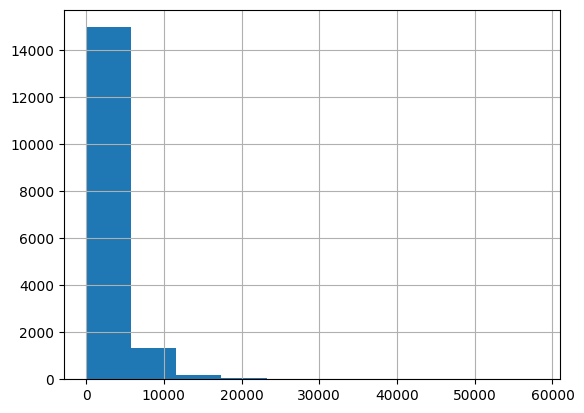

In [9]:
data['story'].str.len().hist()


In [10]:
import nltk
from nltk import tokenize
nltk.download('punkt')
nltk.download('omw-1.4', quiet=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Mean number of sententes length

In [11]:
data['mean_sentence_length'] = data['story'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
data.head(10)

,story,Length,Word_count,mean_word_length,mean_sentence_length
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000
5,"The book tells the story of Paul Bäumer, a Ge...",4283,770,4.562338,103.487805
6,"Ged is a young boy on Gont, one of the larger...",5850,1066,4.487805,111.519231
7,The story is set in an imaginary American tow...,7263,1297,4.599846,109.060606
8,"Living on Mars, Deckard is acting as a consul...",319,56,4.696429,105.666667
9,Beginning several months after the events in ...,1786,291,5.137457,148.000000


# Summarization

## Load summarization pipeline (T5-base)

In [12]:
summarizer = pipeline("summarization", min_length = 100, max_length = 300, model="t5-base", device = 0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Get sample from data

In [13]:
sample = data.iloc[:500]
sample

,story,Length,Word_count,mean_word_length,mean_sentence_length
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000
...,...,...,...,...,...
495,"At first, the brothers are not a particularly...",997,162,5.154321,109.888889
496,The book is presented as a manuscript by its ...,3577,597,4.991625,142.120000
497,Fleming structured the novel in three section...,4360,719,5.063978,154.750000
498,Ironweed is set during the Great Depression a...,484,80,5.050000,160.666667


## Run summarization process

In [14]:
tqdm.pandas()
sample['summary'] = sample['story'].progress_apply(
        lambda story: summarizer(story)[0]['summary_text'])
sample

100%|██████████| 500/500 [22:47<00:00,  2.74s/it]
<ipython-input-14-abbcf67a97fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['summary'] = sample['story'].progress_apply(


,story,Length,Word_count,mean_word_length,mean_sentence_length,summary
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462,john sutter: the original purpose of the Seven...
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905,characterized as a sociopath and a hardened ju...
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639,"the plague is sweeping the town of Oran, where..."
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597,"s.e. cuthbertson: in the Enquiry, he argues th..."
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000,novel posits that space around the Milky Way i...
...,...,...,...,...,...,...
495,"At first, the brothers are not a particularly...",997,162,5.154321,109.888889,young girls' mothers do not regard them as goo...
496,The book is presented as a manuscript by its ...,3577,597,4.991625,142.120000,a middle-aged man named Harry Haller is beset ...
497,Fleming structured the novel in three section...,4360,719,5.063978,154.750000,'happenstance' is about a british secret servi...
498,Ironweed is set during the Great Depression a...,484,80,5.050000,160.666667,ironweed tells the story of an alcoholic vagra...


In [15]:
sample.to_csv('output.csv', index=False)

In [16]:
sample

,story,Length,Word_count,mean_word_length,mean_sentence_length,summary
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462,john sutter: the original purpose of the Seven...
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905,characterized as a sociopath and a hardened ju...
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639,"the plague is sweeping the town of Oran, where..."
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597,"s.e. cuthbertson: in the Enquiry, he argues th..."
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000,novel posits that space around the Milky Way i...
...,...,...,...,...,...,...
495,"At first, the brothers are not a particularly...",997,162,5.154321,109.888889,young girls' mothers do not regard them as goo...
496,The book is presented as a manuscript by its ...,3577,597,4.991625,142.120000,a middle-aged man named Harry Haller is beset ...
497,Fleming structured the novel in three section...,4360,719,5.063978,154.750000,'happenstance' is about a british secret servi...
498,Ironweed is set during the Great Depression a...,484,80,5.050000,160.666667,ironweed tells the story of an alcoholic vagra...


In [29]:
sample.story.iloc[30]

' "Starting in the Middle", Part I of Darwin\'s Dangerous Idea, gets its name from a quote by Willard Van Orman Quine: "Analyze theory-building how we will, we all must start in the middle. Our conceptual firsts are middle-sized, middle-distance objects, and our introduction to them and to everything comes midway in the cultural evolution of the race." The first chapter "Tell Me Why" is named after a song. Before Charles Darwin, God was seen as the ultimate cause of all design, or the ultimate answer to \'why?\' questions. John Locke argued for the primacy of mind before matter, and David Hume, while exposing problems with Locke\'s view, could not see any alternative. Darwin provided just such an alternative: evolution. Besides providing evidence of common descent, he introduced a mechanism to explain it: natural selection. According to Dennett, natural selection is a mindless, mechanical and algorithmic process&mdash;Darwin\'s dangerous idea. The third chapter introduces the concept o

In [28]:
sample.summary.iloc[30]

'"Starting in the middle" is part I of Darwin\'s Dangerous Idea . the book discusses the origin and evolution of morality . it concludes by asking if ethics can be \'naturalized\' the book concludes with "the future of an idea" the author concludes that morality is the product of \'greedy ethical reductionism\' he concludes there is not much hope of discovering an algorithm for doing the right thing .'